## Imports

In [1]:
import os
from datetime import datetime

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (20, 10)

## Load data

In [2]:
data_root = os.path.join('..', 'data', 'main')

In [3]:
data = pd.read_csv(os.path.join(data_root, "fact_train_test.csv"), sep=";", decimal=",", encoding="windows-1251")
data["period"] = data["period"].astype("datetime64[ns]")

In [4]:
data.head()

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1


## Preprocess data

In [5]:
def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    # = Пути к справочникам - откорректировать если в реальной системе будут лежать по другому адресу =
    client_mapping_file = os.path.join(data_root, "client_mapping.csv")
    freight_mapping_file = os.path.join(data_root, "freight_mapping.csv")
    station_mapping_file = os.path.join(data_root, "station_mapping.csv")

    # Клиент - холдинг
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")

    # Груз
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")

    # Станции
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df

In [6]:
extended_data = add_master_data_mappings(data)

In [7]:
extended_data.head()

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1,1423.0,21,153,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3,1423.0,21,153,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1,1423.0,30,153,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1,1423.0,30,153,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1,1423.0,30,153,12,94,39


In [8]:
extended_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559232 entries, 0 to 3559231
Data columns (total 17 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   period                     datetime64[ns]
 1   rps                        int64         
 2   podrod                     int64         
 3   filial                     int64         
 4   client_sap_id              int64         
 5   freight_id                 int64         
 6   sender_station_id          int64         
 7   recipient_station_id       int64         
 8   sender_organisation_id     int64         
 9   real_weight                float64       
 10  real_wagon_count           int64         
 11  holding_name               float64       
 12  freight_group_name         int64         
 13  sender_department_name     int64         
 14  sender_railway_name        int64         
 15  recipient_department_name  int64         
 16  recipient_railway_name     int64    

In [9]:
def fix_types(df: pd.DataFrame):
    col_type_dict = {
        'rps': 'int8',
        'podrod': 'int8',
        'filial': 'int8',
        'client_sap_id': 'int16',
        'freight_id': 'int16',
        'sender_station_id': 'int32',
        'recipient_station_id': 'int32',
        'sender_organisation_id': 'int32',
        'real_weight': 'float64',
        'real_wagon_count': 'int32',
        'holding_name': 'int16',
        'freight_group_name': 'int8',
        'sender_department_name': 'int8',
        'sender_railway_name': 'int8',     
        'recipient_department_name': 'int8',     
        'recipient_railway_name': 'int8', 
    }

    for col_name, col_type in col_type_dict.items():
        df[col_name] = df[col_name].astype(col_type)

    return df

In [10]:
extended_data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1,1423.0,21,153,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3,1423.0,21,153,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1,1423.0,30,153,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1,1423.0,30,153,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1,1423.0,30,153,12,94,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,69.0,1,2226.0,22,73,14,143,35
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,70.0,1,2226.0,22,73,14,79,10
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,70.0,1,2226.0,22,73,14,104,10
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,207.0,3,2226.0,22,73,14,143,35


In [11]:
extended_data.loc[extended_data['holding_name'].isna(), 'holding_name'] = -1 
extended_data = fix_types(extended_data)

In [12]:
extended_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559232 entries, 0 to 3559231
Data columns (total 17 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   period                     datetime64[ns]
 1   rps                        int8          
 2   podrod                     int8          
 3   filial                     int8          
 4   client_sap_id              int16         
 5   freight_id                 int16         
 6   sender_station_id          int32         
 7   recipient_station_id       int32         
 8   sender_organisation_id     int32         
 9   real_weight                float64       
 10  real_wagon_count           int32         
 11  holding_name               int16         
 12  freight_group_name         int8          
 13  sender_department_name     int8          
 14  sender_railway_name        int8          
 15  recipient_department_name  int8          
 16  recipient_railway_name     int8     

In [14]:
extended_data.to_csv(os.path.join('..', 'data', 'train', 'extended_dataset.csv'), index=False)

## Data description

In [18]:
data_desc = pd.read_excel(os.path.join(data_root, 'Описание данных для хакатона - прогноз ЖД перевозок.xlsx')).iloc[1:]
data_desc = pd.DataFrame(data=data_desc.iloc[1:].values, columns=data_desc.iloc[0].values)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 1000)

In [19]:
data_desc

,Поле,Тип данных,Описание
0,period,date,"Месяц предъявления отправки к перевозке в формате ""YYYY-MM-DD"""
1,rps,integer,Род Подвижного Состава
2,podrod,integer,Подрод Подвижного Состава
3,filial,integer,"Филиал ""ПГК"""
4,client_sap_id,integer,Код отправителя
5,freight_id,integer,Код груза
6,sender_station_id,integer,Код пункта отправления
7,recipient_station_id,integer,Код пункта назначения
8,sender_organisation_id,integer,Код погрузочно-выгрузочного пункта
9,real_weight,float,"Суммарный вес фактически перевезенного груза, тонн"


In [20]:
data.describe()

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
count,3559232,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06
mean,2020-01-01 04:50:29.038176256,5.979641e-01,3.338106e+00,1.148843e+00,3.865685e+02,1.712424e+03,2.628122e+04,2.598168e+04,1.499681e+04,1.349654e+03,1.988760e+01
min,2012-07-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+00,0.000000e+00
25%,2018-06-01 00:00:00,0.000000e+00,2.000000e+00,1.000000e+00,-1.000000e+00,1.059000e+03,1.427200e+04,1.373100e+04,7.856000e+03,6.500000e+01,1.000000e+00
50%,2020-01-01 00:00:00,1.000000e+00,5.000000e+00,1.000000e+00,1.080000e+02,1.622000e+03,3.051900e+04,3.079000e+04,1.202600e+04,1.300000e+02,2.000000e+00
75%,2021-08-01 00:00:00,1.000000e+00,5.000000e+00,1.000000e+00,6.010000e+02,2.219000e+03,3.519600e+04,3.519600e+04,2.201100e+04,3.990000e+02,6.000000e+00
max,2023-03-01 00:00:00,1.000000e+00,9.000000e+00,2.000000e+00,2.417000e+03,5.086000e+03,3.912300e+04,3.912300e+04,3.453600e+04,8.204350e+05,1.180900e+04
std,NaN,4.903092e-01,1.964952e+00,5.305394e-01,5.398728e+02,1.029591e+03,1.110980e+04,1.146103e+04,8.048006e+03,9.062866e+03,1.301516e+02


In [21]:
data.shape

(3559232, 11)

**Особенности данных**

`rps` - имеет 2 значения (большие и малые вагоны)

`podrod` - имеет 7 различных значений

`filial` - имеет 2 уникальных значения

`real_weight` - имеет выбросы (от -6 до -1)

<Axes: xlabel='rps', ylabel='count'>

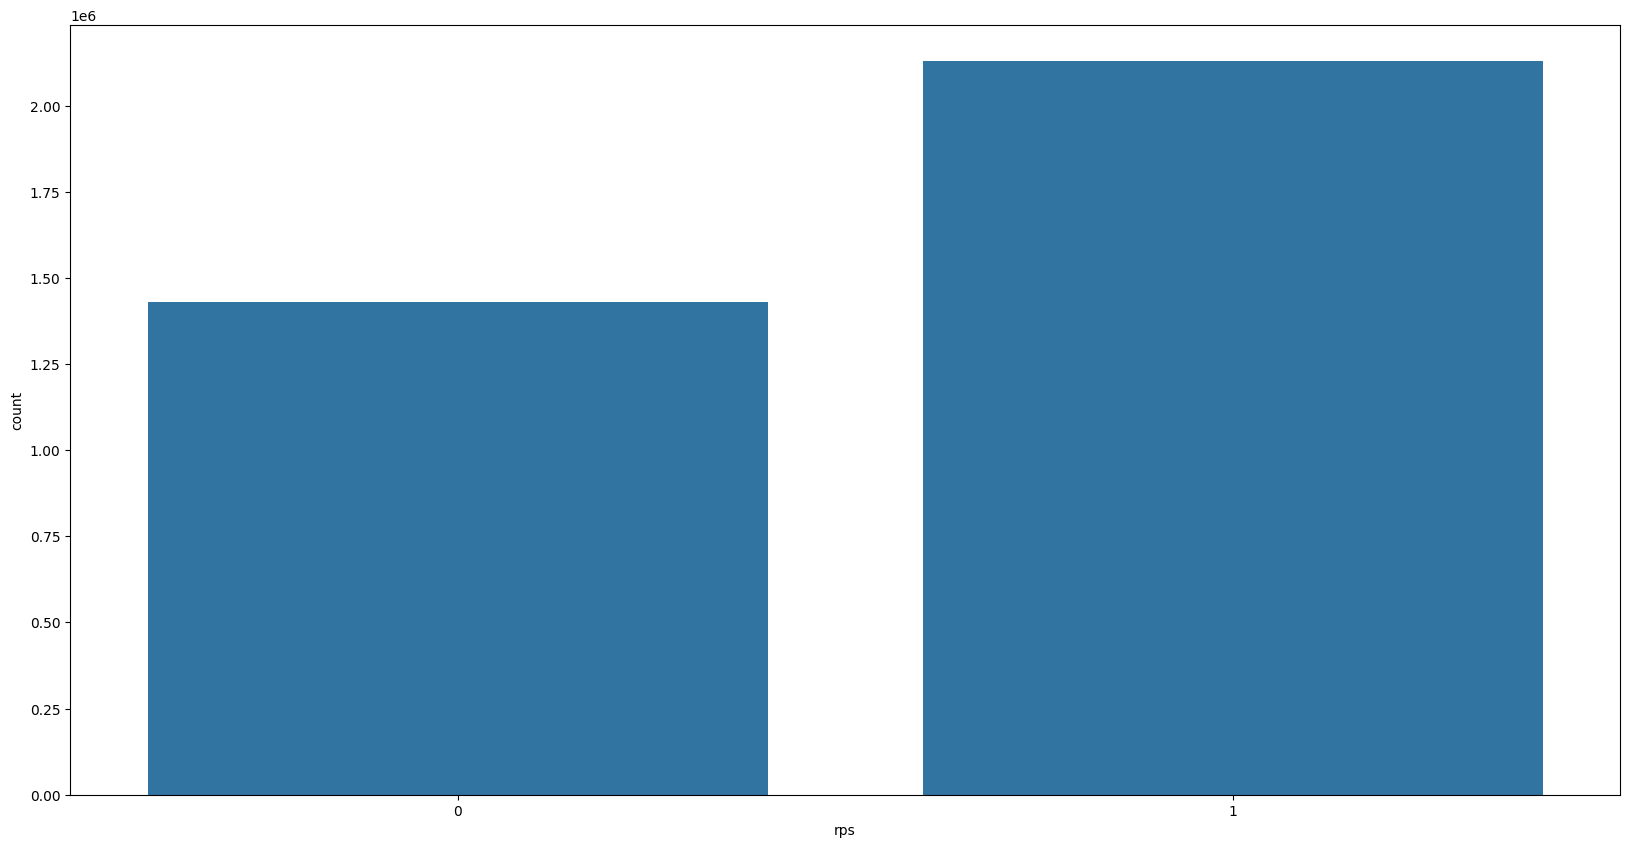

In [31]:
sns.barplot(data.rps.value_counts())

<Axes: xlabel='podrod', ylabel='count'>

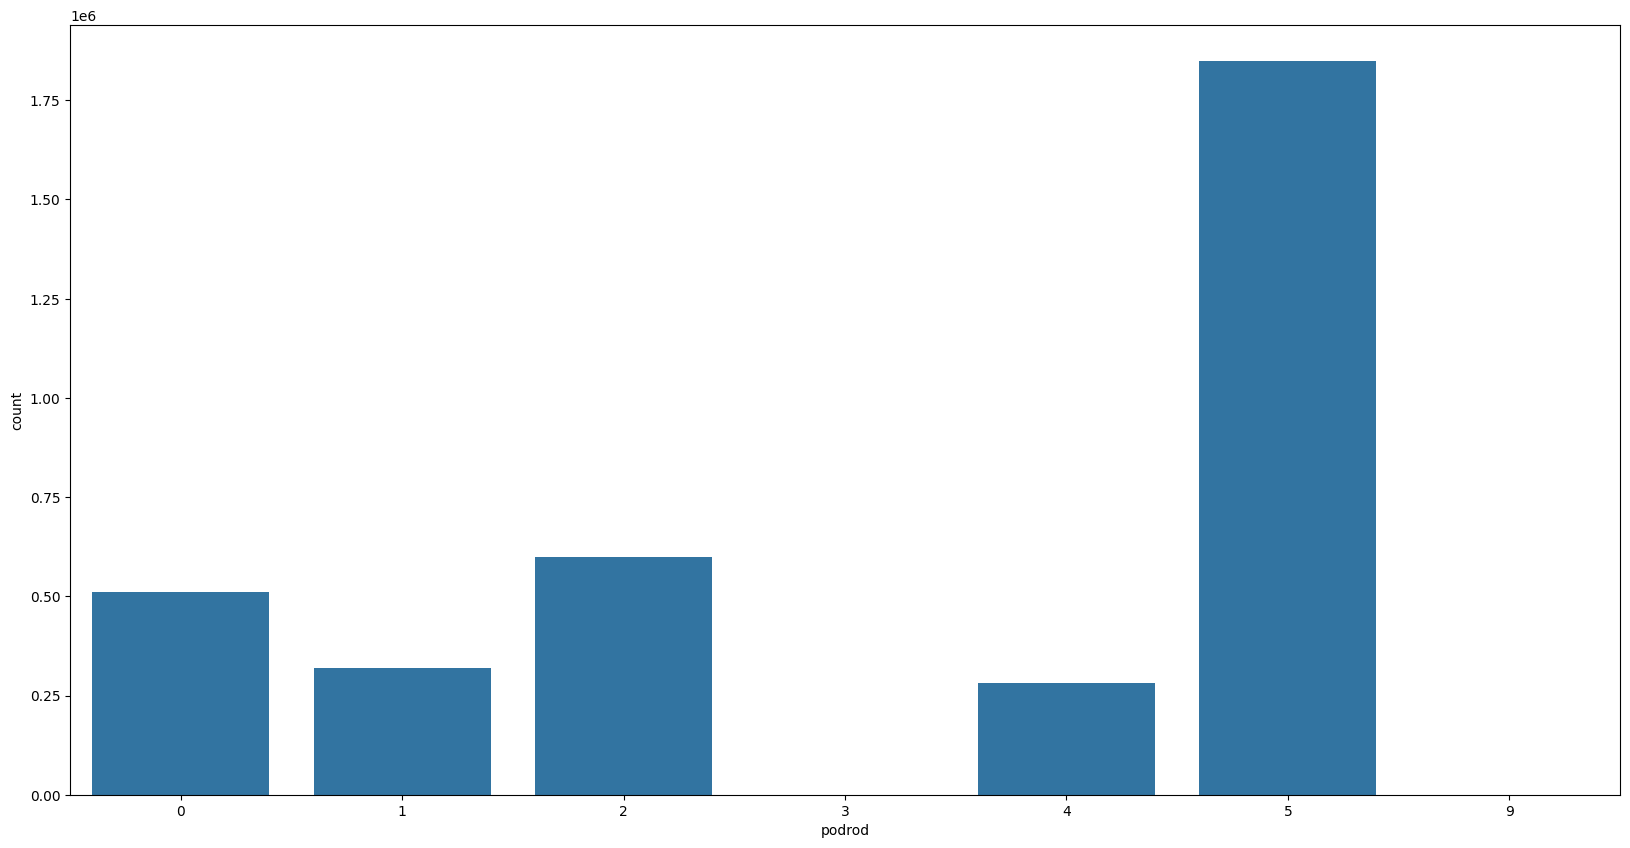

In [30]:
sns.barplot(data.podrod.value_counts())

In [49]:
target_granularity = [
    "period",
    "rps",
    "holding_name",
    "sender_department_name",
    "recipient_department_name",
]

In [52]:
shorten_data.index = shorten_data['period']

In [55]:
shorten_data.drop(columns='period', inplace=True)

/tmp/ipykernel_5473/1412300677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shorten_data.drop(columns='period', inplace=True)


In [81]:
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1
...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,69.0,1
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,70.0,1
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,70.0,1
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,207.0,3


In [80]:
shorten_data

,rps,holding_name,sender_department_name,recipient_department_name,real_wagon_count
period,,,,,
2012-07-01,1,1423,-103,75,1
2012-10-01,1,1423,-103,99,3
2014-03-01,0,1423,-103,16,1
2014-03-01,0,1423,-103,118,1
2014-03-01,0,1423,-103,94,1
...,...,...,...,...,...
2023-03-01,1,2226,73,-113,1
2023-03-01,1,2226,73,79,1
2023-03-01,1,2226,73,104,1


In [109]:
abc = extended_data.drop(columns='period').groupby([
    "rps",
    "client_sap_id",
    "sender_department_name",
    "recipient_department_name",]).sum()#.shape

In [111]:
abc

podrod  filial  freight_id  sender_station_id  recipient_station_id  sender_organisation_id  real_weight  real_wagon_count  holding_name  freight_group_name  sender_railway_name  recipient_railway_name
rps client_sap_id sender_department_name recipient_department_name                                                                                                                                                                                                           
0   -1            -127                   -114                            0       4           0              62578                 64186                       0        240.0                 4            -2                   0                   24                      64
                                         -113                            2       2        1714              31289                 31502                   26746        128.0                 2            -1                  37                   12                      35
                                         -103                            2       4        1449              62558                 60352                       0        135.0                 2            -2                  31                   24                      24
                                         -93                            20      36           0             563022                557278                    4173       2054.0                31           -18                   0                  216                     216
                                          2                             88     132       10368            2064414               2031575                   58530       7892.0               118           -66                 248                  792                     792
...                                                                    ...     ...         ...                ...                   ...                     ...          ...               ...           ...                 ...                  ...                     ...
1    2415          119                    118                           30      12        9486             196790                173666                   71266       1867.0                27         12276                 154                  174                      66
                                          119                           50      20       20211             328000                326195                   71780       1131.0                17         20460                 308                  290                     290
                                          120                           20       8        5936             131195                  4982                   42811        900.0                13          8184                  98                  116                     100
                                          123                           15       6        7071              98385                 74188                   63831        413.0                 6          6138                 105                   87                      93
     2416          86                     94                            10       4        3382              54192                 54968                   21158        260.0                 4          3870                  78                   78                      78

[77477 rows x 12 columns]

In [126]:
features_list = [
    "period",
    "rps",
    "holding_name",
    "recipient_station_id",
    "sender_station_id",
    "sender_department_name",
    "recipient_department_name",
]

shorten_data = extended_data[features_list + ['real_wagon_count']]

# abc = extended_data.drop(columns='period').groupby([
#     "rps",
#     "holding_name",
#     "recipient_station_id",
#     "sender_station_id",
#     "sender_department_name",
#     "recipient_department_name",]).sum()

In [119]:
abc

podrod  filial  client_sap_id  freight_id  sender_organisation_id  real_weight  real_wagon_count  freight_group_name  sender_railway_name  recipient_railway_name
rps holding_name recipient_station_id sender_station_id sender_department_name recipient_department_name                                                                                                                                                                   
0   -1           0                    0                  0                      0                              3      22            -11       21304                  283888       1070.0                17                 223                    0                       0
                                      1848              -123                    0                             20      12            -10       34800                   99882        640.0                10                  90                  250                       0
                                      8432              -118                    0                              0       1             -1         437                   15601         64.0                 1                  10                   23                       0
                                      14016             -117                    0                              0       4             -2         790                   29798       1320.0                22                  36                   60                       0
                                      14019             -117                    0                              0       8             -4        1580                   28784       1943.0                32                  72                  120                       0
...                                                                                                          ...     ...            ...         ...                     ...          ...               ...                 ...                  ...                     ...
1    2243        38808                37457             -110                    23                            35       0          11263        8158                  138489        481.0                 7                 147                   21                      42
                 38811                37457             -110                    23                            10       0           3218        2332                   21446        138.0                 2                  42                    6                      12
                 38834                37457             -110                    23                            35       1          11263        8160                  106775        484.0                 7                 147                   21                      42
                 38880                37457             -110                    23                             5       0           1609        1012                   10723        138.0                 2                  31                    3                       6
                 38986                37457             -110                   -121                           10       2           3218        2332                   21446        207.0                 3                  42                    6                      12

[308910 rows x 10 columns]

In [82]:
shorten_data[shorten_data['sender_department_name'] == shorten_data['recipient_department_name']]

,rps,holding_name,sender_department_name,recipient_department_name,real_wagon_count
period,,,,,
2016-12-01,0,-1,23,23,1
2016-12-01,0,-1,110,110,2
2016-12-01,0,-1,93,93,3
2016-12-01,0,-1,93,93,2
2016-12-01,0,-1,23,23,1
...,...,...,...,...,...
2023-03-01,1,2117,-122,-122,1
2023-03-01,1,2117,26,26,13
2023-03-01,1,2117,26,26,2


In [ ]:
for a, b in shorten_data['a', 'b'].iterrows():
    a + b

In [ ]:
shorten_data['a'] + shorten_data['b']

In [ ]:
shorten_data[shorten_data['sender_department_name'] == -1]

In [128]:
y_counts = list()

for _, item in shorten_data.groupby(features_list[1:]):
    item = item.groupby('period').sum()
    
    x = item.index
    y = item.real_wagon_count
    y_counts.append(y.shape[0])

    # if y.shape[0] > 10:
    #     plt.title(item)
    #     plt.scatter(x, y)
        
    #     break

In [93]:
import numpy as np

In [97]:
pd.Series(y_counts).mode()

0    1
dtype: int64

In [ ]:
y = k_1 * month_1 + k_2 * month_2

<Axes: ylabel='Count'>

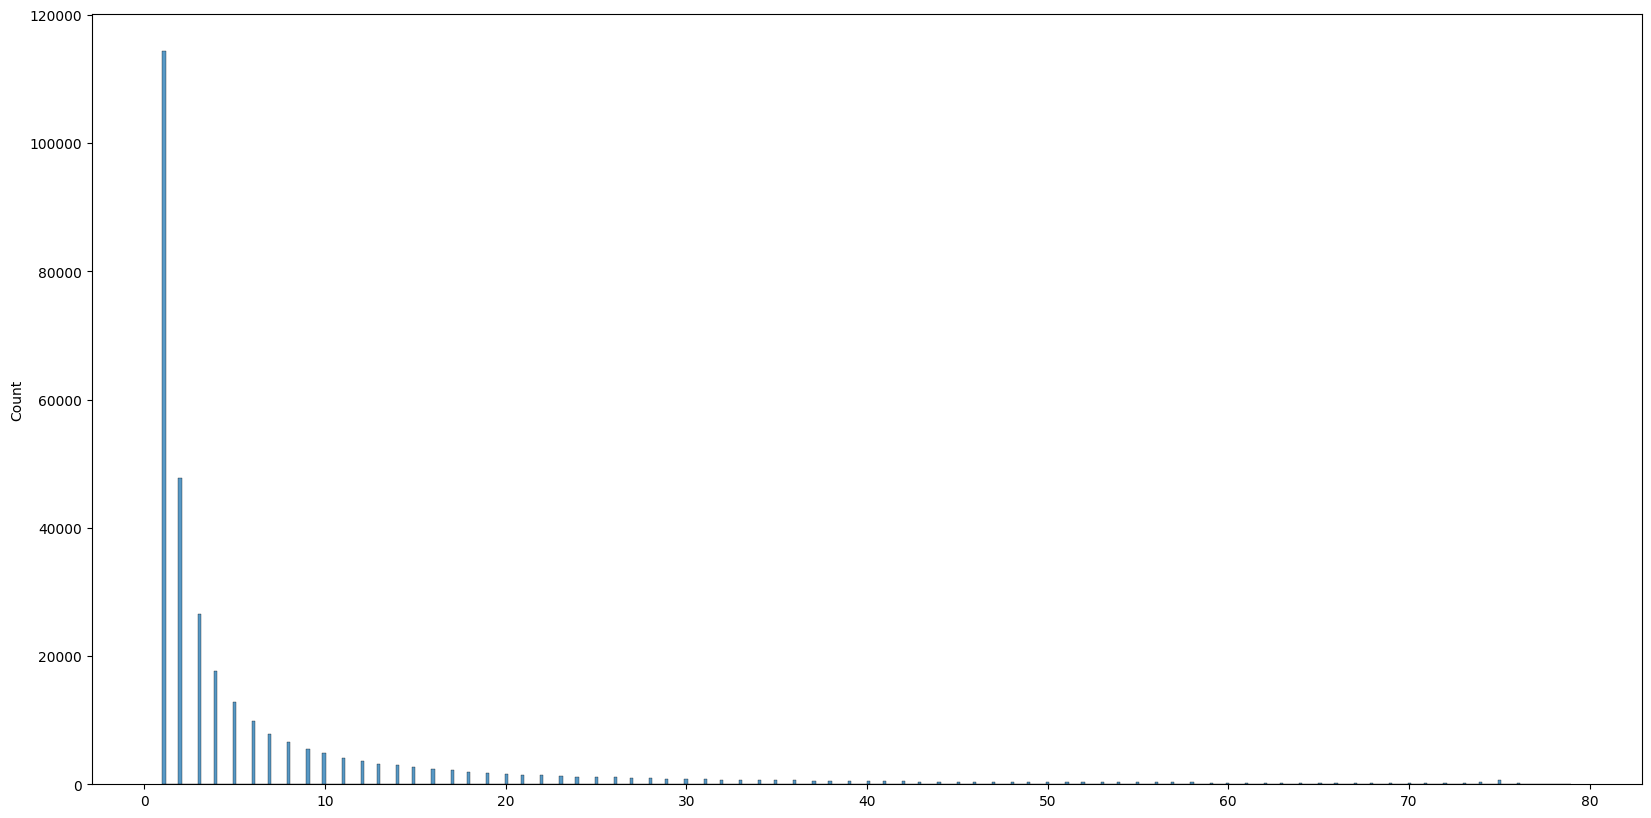

In [129]:
sns.histplot(y_counts)

In [62]:
shorten_data[(shorten_data['rps'] == 0) & (shorten_data['holding_name'] == -1) & (shorten_data['sender_department_name'] == -127) & (shorten_data['recipient_department_name'] == -114)]

,rps,holding_name,sender_department_name,recipient_department_name,real_wagon_count
period,,,,,
2018-05-01,0,-1,-127,-114,3
2018-06-01,0,-1,-127,-114,1


In [50]:
shorten_data = extended_data[target_granularity + ['real_wagon_count']]

In [45]:
grouped_short_data

real_wagon_count
rps holding_name sender_department_name recipient_department_name                  
0   -1           -127                   -114                                      4
                                        -113                                      2
                                        -103                                      2
                                        -93                                      31
                                         2                                      118
...                                                                             ...
1    2243        -110                    78                                     931
                                         79                                     710
                                         104                                    389
                                         109                                     27
                  78                    -110                                      1

[75089 rows x 1 columns]

In [67]:
sorted(extended_data['period'].value_counts().index)

[Timestamp('2012-07-01 00:00:00'),
 Timestamp('2012-10-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00'),
 Timestamp('2015-11-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-08-01 00:00:00'),
 Timestamp('2016-12-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-03-01 00:00:00'),
 Timestamp('2017-04-01 00:00:00'),
 Timestamp('2017-05-01 00:00:00'),
 Timestamp('2017-06-01 00:00:00'),
 Timestamp('2017-07-01 00:00:00'),
 Timestamp('2017-08-01 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-10-01 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-

In [75]:
train_data = extended_data[extended_data['period'] < '2022.11.01']

In [77]:
train_data.to_csv(os.path.join('..', 'data', 'train', 'train_data.csv'), index=False)

In [70]:
test_data = extended_data[extended_data['period'] >= '2022.11.01']

In [74]:
test_data.to_csv(os.path.join('..', 'data', 'train', 'test_data.csv'), index=False)

In [44]:
grouped_short_data = shorten_data.groupby(target_granularity).sum()

In [39]:
grouped_short_data.reset_index()

,period,rps,holding_name,sender_department_name,recipient_department_name,real_wagon_count
0,2012-07-01,1,1423,-103,75,1
1,2012-10-01,1,1423,-103,99,3
2,2014-03-01,0,1423,-103,16,1
3,2014-03-01,0,1423,-103,94,1
4,2014-03-01,0,1423,-103,118,1
...,...,...,...,...,...,...
1031292,2023-03-01,1,2243,-110,-102,2
1031293,2023-03-01,1,2243,-110,55,2
1031294,2023-03-01,1,2243,-110,78,10
1031295,2023-03-01,1,2243,-110,79,1
